# Thesis: Nowcasting for Migrant Flows and Stocks Using Scikit-Learn Pipeline

-   Name: Michelle Schultze
-   Date: 24 March 2025

This file's purpose is to extend the 2021-23 flow and 2010-16 stock variables to span 2018-24 (yearly) and 2010-24 (monthly), respectively. To do so, we will leverage scikit-learn to streamline the process of tuning, evaluating, selecting, and predicting with various machine learning models. 

## __Part 1:__ Extending the 2021-23 annual flows dataset


### Preprocessing the data

In [1]:
# Load in the full dataset with the full range of 2018-2024 data. 

import pandas as pd

# Load the data
file_path = "/Users/michelle/Documents/thesis/region-year-data.csv"
df = pd.read_csv(file_path)

# Extract columns containing "flow" as y_{name}
y = df.filter(like="flow").add_prefix("y_")

# Split y into separate variables based on column names
for column in y.columns:
    globals()[column] = y[column]

# Extract X (all other columns that are NOT in y)
X = df.drop(columns=df.filter(like="flow").columns)

# Display summary
print("Y shape:", y.shape)
print("X shape:", X.shape)

#print(y_Inflow.head())

Y shape: (567, 3)
X shape: (567, 196)


In [2]:
#We are just running XGBoost but with covariates this time, since it seems to perform best! 

column_names = X.columns.tolist()
##print(column_names)
#X = X.loc[:, : "count_zolotaya_korona_average_log_lag"]
#column_names = X.columns.tolist()
print(column_names)

['Region', 'Year', 'count_ailyk_sum', 'count_ailyk_average', 'count_aviabilet_bishkek_sum', 'count_aviabilet_bishkek_average', 'count_bilet_bishkek_sum', 'count_bilet_bishkek_average', 'count_jumush_izdeim_sum', 'count_jumush_izdeim_average', 'count_jumush_sum', 'count_jumush_average', 'count_perevod_deneg_v_kyrgyzstan_sum', 'count_perevod_deneg_v_kyrgyzstan_average', 'count_perevod_deneg_sum', 'count_perevod_deneg_average', 'count_poisk_raboty_sum', 'count_poisk_raboty_average', 'count_rabota_sum', 'count_rabota_average', 'count_unistream_kyrgyzstan_sum', 'count_unistream_kyrgyzstan_average', 'count_unistream_sum', 'count_unistream_average', 'count_vakancii_sum', 'count_vakancii_average', 'count_zarplata_sum', 'count_zarplata_average', 'count_zolotaya_korona_kyrgyzstan_sum', 'count_zolotaya_korona_kyrgyzstan_average', 'count_zolotaya_korona_sum', 'count_zolotaya_korona_average', 'pct_ailyk_average', 'pct_aviabilet_bishkek_average', 'pct_bilet_bishkek_average', 'pct_jumush_izdeim_avera

In [3]:
# NA handling

# Check for NaN values in each column and count the number of missing values per column
missing_counts = X.isna().sum()

# Print columns with missing values and how many missing values in each
print(missing_counts[missing_counts > 0])
print(missing_counts[missing_counts > 1])

# Alternatively, check if a column has "lag" in its name and filter out columns
lag_columns = [col for col in X.columns if 'lag' in col]

# Filter out columns that contain "lag" in their name
X_filtered = X.drop(columns=lag_columns)

# Filter out columns with exactly 1 missing value
X_filtered = X_filtered.loc[:, X_filtered.isna().sum() != 1]

missing_counts = X_filtered.isna().sum()

# Print columns with missing values and how many missing values in each
print(missing_counts[missing_counts > 0])

#poverty_rate                 81
#change_in_output              2
#change_in_real_avg_wages     81
#minwagevalue                243
#log_minwagevalue            243
#lag_log_minwagevalue        244

# List of columns to drop
columns_to_drop = [
    'poverty_rate',
    'change_in_output',
    'change_in_real_avg_wages',
    'minwagevalue',
    'log_minwagevalue',
    'lag_log_minwagevalue'
]

# Drop the specified columns from the DataFrame X
X = X.drop(columns=columns_to_drop)

#Drop the first year so that we don't have to worry about lag NAs
X = X.loc[X["Year"] > 2018]  # Keep only rows after the first year

# Print columns with missing values and how many missing values in each
missing_counts = X.isna().sum()
print(missing_counts[missing_counts > 0])

print(X.describe())

count_ailyk_sum_lag                    1
count_ailyk_average_lag                1
count_aviabilet_bishkek_sum_lag        1
count_aviabilet_bishkek_average_lag    1
count_bilet_bishkek_sum_lag            1
                                      ..
lag_log_mediazona                      1
lag_log_total_pop                      1
lag_log_city_pop                       1
lag_log_rural_pop                      1
lag_log_avg_nominal_gross_wages        1
Length: 99, dtype: int64
poverty_rate                 81
change_in_output              2
change_in_real_avg_wages     81
minwagevalue                243
log_minwagevalue            243
lag_log_minwagevalue        244
dtype: int64
poverty_rate                 81
change_in_output              2
change_in_real_avg_wages     81
minwagevalue                243
log_minwagevalue            243
dtype: int64
Series([], dtype: int64)
              Year  count_ailyk_sum  count_ailyk_average  \
count   486.000000       486.000000           486.000000   
m

In [4]:
# Get a region matrix
region_year_copy = X[['Region', 'Year']].copy()

In [5]:
# One-hot encode the "Region" column in X
X = pd.get_dummies(X, columns=['Region'], drop_first=False, dtype=int)

#print(X.head())

In [6]:
# Split data
X_train = X[X["Year"].isin([2021, 2022])].drop(columns=["Year"])
y_Inflow_train = y_Inflow.loc[X_train.index]  # Use X_train's index
y_Outflow_train = y_Outflow.loc[X_train.index]
y_Netflow_train = y_Netflow.loc[X_train.index]

X_val = X[X["Year"] == 2023].drop(columns=["Year"])
y_Inflow_val = y_Inflow.loc[X_val.index]  # Use X_val's index
y_Outflow_val = y_Outflow.loc[X_val.index]
y_Netflow_val = y_Netflow.loc[X_val.index]


# Display summary
print("X_train shape:", X_train.shape)
print("y_train shape:", y_Inflow_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_Inflow_val.shape)

#print(X_train.head())
#print(y_Inflow_train.head())

X_train shape: (162, 269)
y_train shape: (162,)
X_val shape: (81, 269)
y_val shape: (81,)


In [7]:
# Scale numeric features
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# 1) For X_train
dummies = X_train.loc[:, (X_train.max() == 1) & (X_train.min() == 0)]
X_train_continuous = X_train.drop(columns=dummies.columns)
X_train_scaled = scaler.fit_transform(X_train_continuous)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_continuous.columns, index=X_train_continuous.index)
X_train_scaled = pd.concat([X_train_scaled, dummies], axis=1)

#print("Columns being transformed (continuous variables):")
#print(X_train_continuous.columns.tolist())
#print("\nColumns NOT being transformed (binary/categorical variables):")
#print(dummies.columns.tolist())

# 2) For X_val
dummies = X_val.loc[:, (X_val.max() == 1) & (X_val.min() == 0)]
X_val_continuous = X_val.drop(columns=dummies.columns)
X_val_scaled = scaler.transform(X_val_continuous)  # Use transform only
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_continuous.columns, index=X_val_continuous.index)
X_val_scaled = pd.concat([X_val_scaled, dummies], axis=1)

#print("Columns being transformed (continuous variables):")
#print(X_val_continuous.columns.tolist())
#print("\nColumns NOT being transformed (binary/categorical variables):")
#print(dummies.columns.tolist())

# 3) For X
# Check if 'Year' column is in X
if 'Year' in X.columns:
    print("Yes, 'Year' is in X.")
else:
    print("No, 'Year' is not in X.")

dummies = X.loc[:, (X.max() == 1) & (X.min() == 0)]
# Add the "Year" column to the dummies DataFrame for processing purposes
dummies = pd.concat([dummies, X['Year']], axis=1)
X_continuous = X.drop(columns=dummies.columns)
X_scaled = scaler.transform(X_continuous)
X_scaled = pd.DataFrame(X_scaled, columns=X_continuous.columns, index=X_continuous.index)
X_scaled = pd.concat([X_scaled, dummies], axis=1)

#print("Columns being transformed (continuous variables):")
#print(X_continuous.columns.tolist())
#print("\nColumns NOT being transformed (binary/categorical variables):")
#print(dummies.columns.tolist())

# Display the result
#print(X_val_scaled.head(5))
#print(X_train_scaled.head(5))
#print(X_scaled.head(5))

#print(X_train_scaled.describe())

# Standardize the target variable
yscaler = StandardScaler()
y_Inflow_train_scaled = yscaler.fit_transform(y_Inflow_train.values.reshape(-1, 1)).ravel()
y_Inflow_val_scaled = yscaler.transform(y_Inflow_val.values.reshape(-1, 1)).ravel()
y_Inflow_scaled = yscaler.transform(y_Inflow.values.reshape(-1, 1)).ravel()

outyscaler = StandardScaler()
y_Outflow_train_scaled = outyscaler.fit_transform(y_Outflow_train.values.reshape(-1, 1)).ravel()
y_Outflow_val_scaled = outyscaler.transform(y_Outflow_val.values.reshape(-1, 1)).ravel()
y_Outflow_scaled = outyscaler.transform(y_Outflow.values.reshape(-1, 1)).ravel()

netyscaler = StandardScaler()
y_Netflow_train_scaled = netyscaler.fit_transform(y_Netflow_train.values.reshape(-1, 1)).ravel()
y_Netflow_val_scaled = netyscaler.transform(y_Netflow_val.values.reshape(-1, 1)).ravel()
y_Netflow_scaled = netyscaler.transform(y_Netflow.values.reshape(-1, 1)).ravel()

Yes, 'Year' is in X.


In [8]:
#Create combination sets (Train+Val) for model training at the end

X_trainPLUSval = pd.concat([X_train, X_val], axis=0)
# X_scaled (scaled data)
X_trainPLUSval_scaled = pd.concat([X_train_scaled, X_val_scaled], axis=0)

# 2) Combine target variables for the training and validation sets
y_Inflow_trainPLUSval_scaled = pd.concat(
    [pd.Series(y_Inflow_train_scaled), pd.Series(y_Inflow_val_scaled)], axis=0
)

y_Outflow_trainPLUSval_scaled = pd.concat(
    [pd.Series(y_Outflow_train_scaled), pd.Series(y_Outflow_val_scaled)], axis=0
)

y_Netflow_trainPLUSval_scaled = pd.concat(
    [pd.Series(y_Netflow_train_scaled), pd.Series(y_Netflow_val_scaled)], axis=0
)

y_Inflow_trainPLUSval = pd.concat(
    [pd.Series(y_Inflow_train), pd.Series(y_Inflow_val)], axis=0
)

y_Outflow_trainPLUSval = pd.concat(
    [pd.Series(y_Outflow_train), pd.Series(y_Outflow_val)], axis=0
)

y_Netflow_trainPLUSval = pd.concat(
    [pd.Series(y_Netflow_train), pd.Series(y_Netflow_val)], axis=0
)

In [9]:
# 1) Dimensions for the full dataset (2017-2024)
print("Full dataset (2017-2024) dimensions:")
print("X shape:", X.shape)
print("X_scaled shape:", X_scaled.shape)

# 2) Dimensions for the training set (2021-2022)
print("\nTraining set (2021-2022) dimensions:")
print("X_train shape:", X_train.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_Inflow_train shape:", y_Inflow_train.shape)
print("y_Inflow_trainPLUSval shape:", y_Inflow_train_scaled.shape)
print("y_Outflow_train shape:", y_Outflow_train.shape)
print("y_Netflow_train shape:", y_Netflow_train.shape)

# 3) Dimensions for the validation set (2023)
print("\nValidation set (2023) dimensions:")
print("X_val shape:", X_val.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("y_Inflow_trainPLUSval shape:", y_Inflow_val_scaled.shape)
print("y_Inflow_val shape:", y_Inflow_val.shape)
print("y_Outflow_val shape:", y_Outflow_val.shape)
print("y_Netflow_val shape:", y_Inflow_val.shape)

# 4) Dimensions for the combined train and validation set (2021-2023)
print("\nTrain+Val set (2021-2023) dimensions:")
print("X_trainPLUSval shape:", X_trainPLUSval.shape)
print("X_trainPLUSval_scaled shape:", X_trainPLUSval_scaled.shape)
print("y_Inflow_trainPLUSval_scaled shape:", y_Inflow_trainPLUSval_scaled.shape)
print("y_Outflow_trainPLUSval_scaled shape:", y_Outflow_trainPLUSval_scaled.shape)
print("y_Netflow_trainPLUSval_scaled shape:", y_Netflow_trainPLUSval_scaled.shape)


Full dataset (2017-2024) dimensions:
X shape: (486, 270)
X_scaled shape: (486, 270)

Training set (2021-2022) dimensions:
X_train shape: (162, 269)
X_train_scaled shape: (162, 269)
y_Inflow_train shape: (162,)
y_Inflow_trainPLUSval shape: (162,)
y_Outflow_train shape: (162,)
y_Netflow_train shape: (162,)

Validation set (2023) dimensions:
X_val shape: (81, 269)
X_val_scaled shape: (81, 269)
y_Inflow_trainPLUSval shape: (81,)
y_Inflow_val shape: (81,)
y_Outflow_val shape: (81,)
y_Netflow_val shape: (81,)

Train+Val set (2021-2023) dimensions:
X_trainPLUSval shape: (243, 269)
X_trainPLUSval_scaled shape: (243, 269)
y_Inflow_trainPLUSval_scaled shape: (243,)
y_Outflow_trainPLUSval_scaled shape: (243,)
y_Netflow_trainPLUSval_scaled shape: (243,)


Now we have data readily available for the following:

- X, X_scaled (full set 2017-2024)

- X_train, X_train_scaled (training set: 2021-22)
- y_Inflow_train, y_Outflow_train, y_Netflow_train (training set: 2021-22)

- X_val, X_val_scaled (validation set: 2023)
- y_Inflow_val, y_Outflow_val, y_Netflow_val (validation set: 2023)

- X_trainPLUSval, X_trainPLUSval_scaled (for training at the end! 2021-23)
- y_Inflow_trainPLUSval, y_Outflow_trainPLUSval, y_Netflow_trainPLUSval (2021-23)

### Selecting the right model for prediction

Candidates:
- XGBoost
- Stochastic gradient descent (including elastic net spec)
- Random forest
- Neural network
- Elastic net 

We will get confidence intervals after choosing the highest accuracy model, since the point estimate is the most important component here.

In [10]:
# Packages
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
#!brew install libomp 
#!pip install --force-reinstall xgboost
import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.metrics import mean_squared_error, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [11]:
# Tuning I

# Define a function to fit and tune models
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Define hyperparameter grids for each model
param_grids = {
    'NeuralNetwork': {
        'hidden_layer_sizes': [(10,), (25,), (50,), (75,), (100,), 
                               (10,10), (25,10), (50,20), (75,30), 
                               (100,40), (50, 50), (100, 50), (100, 100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'learning_rate': ['constant', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1, 0.2],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5],
        'early_stopping': [True, False],
        'momentum': [0.9, 0.95, 0.99],
        'max_iter': [1500, 2500, 5000]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 5, 7],
        'subsample': [1.0],
        'colsample_bytree': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 
                             0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
                             0.75, 0.8],
        'gamma': [0, 0.1, 0.3, 0.5],
        'alpha': [0, 0.1, 0.3, 0.5],  
        'lambda': [0, 0.1, 0.3, 0.5]  
    },
    'SGD': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [1000, 1500],
        'penalty': ['l2', 'elasticnet', 'l1'],
        'tol': [1e-3, 1e-4],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'fit_intercept': [True],
        'power_t': [0.5, 0.6, 0.8]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 3, 5],
        'bootstrap': [True],
        'max_features': [None, 'sqrt', 'log2', 5, 10, 20, 30, 50, 100],
        'min_impurity_decrease': [0.0, 0.1, 0.2]
    },
    'ElasticNet': {
        'alpha': [0, 0.01, 0.1, 0.25, 0.5, 0.75,
                  1.0, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000, 3000],
        'fit_intercept': [True],
        'selection': ['cyclic', 'random'], 
        'tol': [1e-4, 1e-5]
    }
}

# Define models for the pipeline
models = {
    'NeuralNetwork': MLPRegressor(),
    'XGBoost': xgboost.XGBRegressor(),
    'SGD': SGDRegressor(),
    'RandomForest': RandomForestRegressor(),
    'ElasticNet': ElasticNet(),
}

#Needs a numpy array
X_trainPLUSval_scaled_np = X_trainPLUSval_scaled.to_numpy()
y_Netflow_trainPLUSval_np = y_Netflow_trainPLUSval_scaled.to_numpy()

print(y_Netflow_trainPLUSval_scaled)
print(y_Netflow_trainPLUSval_scaled.isnull().sum())  # Check for missing values


0    -0.126077
1    -0.354051
2    -0.233137
3    -0.303670
4     0.008692
        ...   
76   -0.302411
77    0.153538
78   -0.005163
79   -0.211725
80   -0.317525
Length: 243, dtype: float64
0


In [12]:
# Tuning III: what if we standardize the y too? 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# Function to tune models automatically over the parameter grid
def tune_all_models(models, param_grids, X_train, y_train, X_val, y_val):
    model_results = {}  # Dictionary to store results for all models

    for model_name, model in models.items():
        print(f"Starting tuning for {model_name}...")

        # Get the parameter grid for the model
        param_grid = param_grids.get(model_name, {})
        if not param_grid:
            print(f"No parameter grid found for {model_name}, skipping model.")
            continue

        # Initialize list to store the results for the current model
        results = []
        i = 0

        # Iterate over all parameter combinations
        for params in ParameterGrid(param_grid):  # Using ParameterGrid to iterate over combinations
            model.set_params(**params)  # Set model parameters

            # Fit the model
            model.fit(X_train_scaled, y_Netflow_train_scaled)

            # Make predictions on the validation set
            y_pred = model.predict(X_val)

            # Calculate the mean squared error
            mse = mean_squared_error(y_Netflow_val_scaled, y_pred)

            # Store the result with the parameter combination
            results.append({'params': params, 'mse': mse})

            i += 1
            if i % 50 == 0:
                print(f"Trained fit {i}/{len(ParameterGrid(param_grid))} for {model_name}. Moving to next.")

        print(f"Finished tuning for {model_name}.")

        # Get the best result (the one with the lowest MSE)
        best_result = min(results, key=lambda x: x['mse'])
        best_params = best_result['params']
        best_mse = best_result['mse']

        # Store the results for the current model
        model_results[model_name] = {
            'best_params': best_params,
            'best_val_mse': best_mse,
            'all_results': results
        }

        print(f"Best Parameters for {model_name}: {best_params}")
        print(f"Best Validation MSE for {model_name}: {best_mse:.4f}\n")

    return model_results

# Example usage: Tuning all models
model_results = tune_all_models(models, param_grids, X_train_scaled, y_Netflow_train_scaled, X_val_scaled, y_Netflow_val_scaled)

# Print out the results for all models
print("Final Results for All Models:")
for model_name, result in model_results.items():
    print(f"{model_name} - Best Params: {result['best_params']}, Best Validation MSE: {result['best_val_mse']:.4f}")


Starting tuning for NeuralNetwork...
Trained fit 50/22464 for NeuralNetwork. Moving to next.
Trained fit 100/22464 for NeuralNetwork. Moving to next.
Trained fit 150/22464 for NeuralNetwork. Moving to next.
Trained fit 200/22464 for NeuralNetwork. Moving to next.
Trained fit 250/22464 for NeuralNetwork. Moving to next.
Trained fit 300/22464 for NeuralNetwork. Moving to next.
Trained fit 350/22464 for NeuralNetwork. Moving to next.
Trained fit 400/22464 for NeuralNetwork. Moving to next.
Trained fit 450/22464 for NeuralNetwork. Moving to next.
Trained fit 500/22464 for NeuralNetwork. Moving to next.
Trained fit 550/22464 for NeuralNetwork. Moving to next.
Trained fit 600/22464 for NeuralNetwork. Moving to next.
Trained fit 650/22464 for NeuralNetwork. Moving to next.
Trained fit 700/22464 for NeuralNetwork. Moving to next.
Trained fit 750/22464 for NeuralNetwork. Moving to next.
Trained fit 800/22464 for NeuralNetwork. Moving to next.
Trained fit 850/22464 for NeuralNetwork. Moving to n

/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

Trained fit 50/612 for ElasticNet. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 100/612 for ElasticNet. Moving to next.
Trained fit 150/612 for ElasticNet. Moving to next.
Trained fit 200/612 for ElasticNet. Moving to next.
Trained fit 250/612 for ElasticNet. Moving to next.
Trained fit 300/612 for ElasticNet. Moving to next.
Trained fit 350/612 for ElasticNet. Moving to next.
Trained fit 400/612 for ElasticNet. Moving to next.
Trained fit 450/612 for ElasticNet. Moving to next.
Trained fit 500/612 for ElasticNet. Moving to next.
Trained fit 550/612 for ElasticNet. Moving to next.
Trained fit 600/612 for ElasticNet. Moving to next.
Finished tuning for ElasticNet.
Best Parameters for ElasticNet: {'alpha': 0.25, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
Best Validation MSE for ElasticNet: 0.2612

Final Results for All Models:
NeuralNetwork - Best Params: {'activation': 'relu', 'alpha': 5, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 

In [13]:
# Sort models by validation MSE
sorted_results = sorted(model_results.items(), key=lambda x: x[1]['best_val_mse'])

# Select the best model (lowest MSE)
best_model_name, best_model_result = sorted_results[0]

# Display sorted results
print("Sorted Model Tuning Results:")
for model_name, result in sorted_results:
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Validation MSE: {result['best_val_mse']:.4f}")

# Display the best model
print("\nBest Model Selected:")
print(f"{best_model_name}:")
print(f"  Best Parameters: {best_model_result['best_params']}")
print(f"  Validation MSE: {best_model_result['best_val_mse']:.4f}")

Sorted Model Tuning Results:
NeuralNetwork:
  Best Parameters: {'activation': 'relu', 'alpha': 5, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 5000, 'momentum': 0.99, 'solver': 'adam'}
  Validation MSE: 0.2428
ElasticNet:
  Best Parameters: {'alpha': 0.25, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
  Validation MSE: 0.2612
RandomForest:
  Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Validation MSE: 0.2690
SGD:
  Best Parameters: {'alpha': 1, 'fit_intercept': True, 'learning_rate': 'adaptive', 'max_iter': 1000, 'penalty': 'elasticnet', 'power_t': 0.8, 'tol': 0.0001}
  Validation MSE: 0.2709
XGBoost:
  Best Parameters: {'alpha': 0.1, 'colsample_bytree': 0.4, 'gamma': 0, 'lambda': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_e

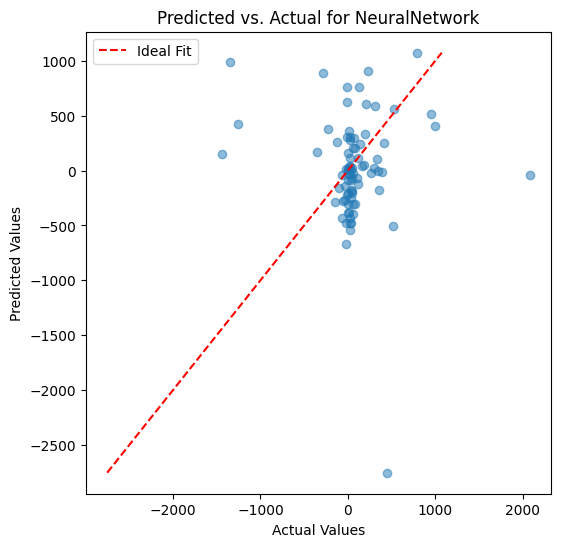

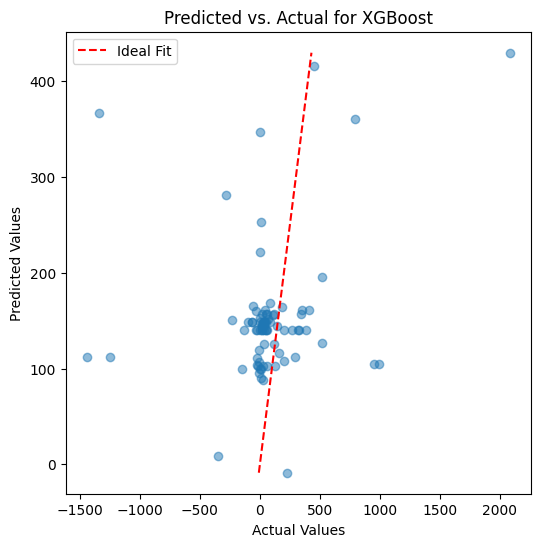

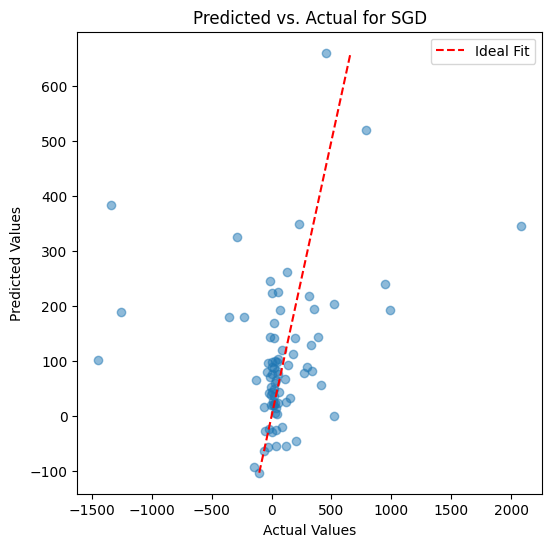

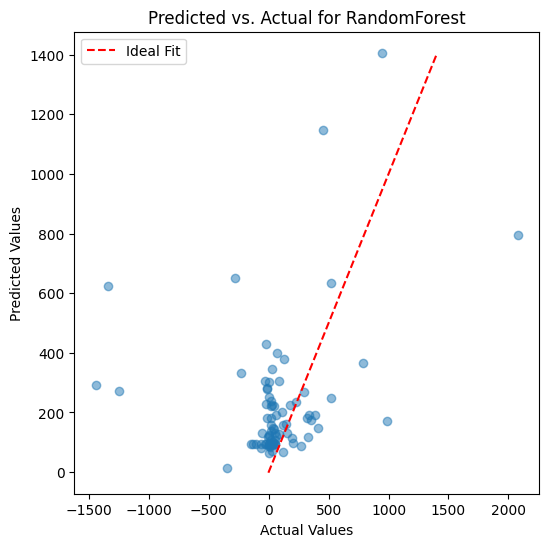

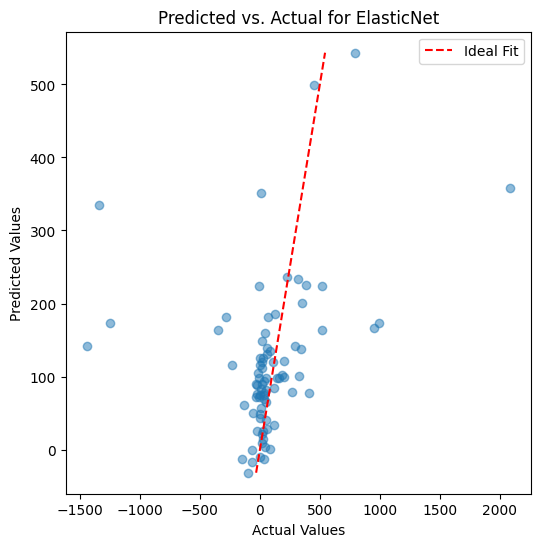

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Generate scatterplots for the best model of each type
for model_name, model in models.items():
    if model_name not in model_results:
        continue  # Skip if the model isn't in the results

    best_params = model_results[model_name]["best_params"]  # Get the best hyperparameters

    # Re-initialize the model with the best parameters
    best_model = model.set_params(**best_params)

    # Fit the model on the training data (if needed)
    best_model.fit(X_train_scaled, y_Netflow_train_scaled)

    # Generate predictions on validation data
    y_pred_scaled = best_model.predict(X_val_scaled)

    # **Inverse transform predictions and actual values**
    y_pred = netyscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Scatterplot of predicted vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_Netflow_val, y_pred, alpha=0.5)

    # Plot y = x line for reference
    min_val, max_val = min(y_Netflow_val_scaled.min(), y_pred.min()), max(y_Netflow_val_scaled.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit")

    # Labels and title
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs. Actual for {model_name}")
    plt.legend()

    # Show the plot
    plt.show()

In [21]:
# Tuning III: greedy grid for best, Elastic Net (because of visual fit)!

from sklearn.model_selection import ParameterGrid

# Define greedy tuning grid
greedy_param_grid = {
        'alpha': [0, 0.01, 0.1, 0.25, 0.5, 0.75,
                  1.0, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'l1_ratio': [0.2, 0.5, 0.7, 0.85, 0.8, 0.85, 0.9, 0.95, 0.99, 1],
        'max_iter': [500, 750, 1000, 1500, 2000, 3000],
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random'], 
        'tol': [1e-4, 5e-4, 1e-5, 5e-5, 1e-6]
}

#ElasticNet: (selected model from before)
#  Best Parameters: {'alpha': 0.25, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
#  Validation MSE: 0.2612


# Create parameter combinations
param_combinations = list(ParameterGrid(greedy_param_grid))

print(f"Total parameter combinations to try: {len(param_combinations)}")


Total parameter combinations to try: 20400


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Initialize best model tracking
best_rmse = float('inf')
best_model = None
best_params = None
i = 0

# Iterate over all parameter combinations
for params in ParameterGrid(greedy_param_grid):
    #print(f"Testing parameters: {params}")

    # Initialize and train the model
    model = ElasticNet(**params)
    model.fit(X_train_scaled, y_Netflow_train_scaled)

    # Predict on validation set
    y_pred_scaled = model.predict(X_val_scaled)

    # **Inverse transform predictions and actual values**
    y_pred = netyscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Compute validation MSE
    val_rmse = np.sqrt(mean_squared_error(y_Netflow_val, y_pred))
    #print(f"Validation MSE: {val_mse:.4f}")

    i += 1
    if i % 50 == 0:
        print(f"Trained fit {i}/{len(ParameterGrid(greedy_param_grid))}. Moving to next.")
    
    # Track best model
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = model
        best_params = params

print("\nBest Model Found:")
print(f"Best Parameters: {best_params}")
print(f"Best Validation RMSE: {best_rmse:.4f}")

/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

Trained fit 50/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.347e-01, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 100/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+00, tolerance: 8.100e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 150/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+00, tolerance: 8.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 200/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+00, tolerance: 8.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 250/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 300/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+00, tolerance: 1.620e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 350/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.347e-01, tolerance: 8.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 400/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 450/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+00, tolerance: 8.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 500/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+00, tolerance: 1.620e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

Trained fit 550/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+00, tolerance: 1.620e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 600/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+00, tolerance: 8.100e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 650/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.351e-01, tolerance: 1.620e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 700/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+00, tolerance: 1.620e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 750/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 800/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e+00, tolerance: 1.620e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 850/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.440e+00, tolerance: 1.620e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 900/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+00, tolerance: 8.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 950/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.351e-01, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 1000/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 1050/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e+00, tolerance: 1.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 1100/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e+00, tolerance: 8.100e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 1150/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.440e+00, tolerance: 1.620e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected result

Trained fit 1200/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.243e+00, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.243e+00, tolerance: 8.100e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1250/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.747e-01, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.747e-01, tolerance: 8.100e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1300/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.423e-04, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.347e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1350/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e-02, tolerance: 8.100e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1400/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1450/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.530e-02, tolerance: 8.100e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.939e-02, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1500/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.621e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.621e-02, tolerance: 8.100e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1550/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.473e-04, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.600e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1600/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.460e-03, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1650/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e-03, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.668e-03, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1700/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e-03, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e-03, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1750/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1800/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.685e+00, tolerance: 8.100e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.685e+00, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1850/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.641e-01, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.641e-01, tolerance: 8.100e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1900/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.082e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.082e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 1950/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.982e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.982e-02, tolerance: 8.100e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2000/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.946e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.946e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2050/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e-02, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2100/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.034e-02, tolerance: 8.100e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2150/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e-04, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.485e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2200/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.309e-03, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.799e-03, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2250/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.562e-03, tolerance: 1.620e-04
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2300/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e-01, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.143e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2350/20400. Moving to next.


/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e-02, tolerance: 1.620e-02
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e-02, tolerance: 1.620e-03
  model = cd_fast.enet_coordinate_descent(
/Users/michelle/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Trained fit 2400/20400. Moving to next.
Trained fit 2450/20400. Moving to next.
Trained fit 2500/20400. Moving to next.
Trained fit 2550/20400. Moving to next.
Trained fit 2600/20400. Moving to next.
Trained fit 2650/20400. Moving to next.
Trained fit 2700/20400. Moving to next.
Trained fit 2750/20400. Moving to next.
Trained fit 2800/20400. Moving to next.
Trained fit 2850/20400. Moving to next.
Trained fit 2900/20400. Moving to next.
Trained fit 2950/20400. Moving to next.
Trained fit 3000/20400. Moving to next.
Trained fit 3050/20400. Moving to next.
Trained fit 3100/20400. Moving to next.
Trained fit 3150/20400. Moving to next.
Trained fit 3200/20400. Moving to next.
Trained fit 3250/20400. Moving to next.
Trained fit 3300/20400. Moving to next.
Trained fit 3350/20400. Moving to next.
Trained fit 3400/20400. Moving to next.
Trained fit 3450/20400. Moving to next.
Trained fit 3500/20400. Moving to next.
Trained fit 3550/20400. Moving to next.
Trained fit 3600/20400. Moving to next.


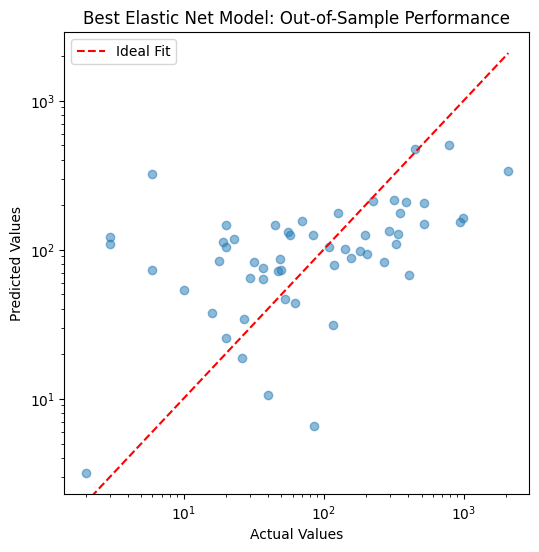

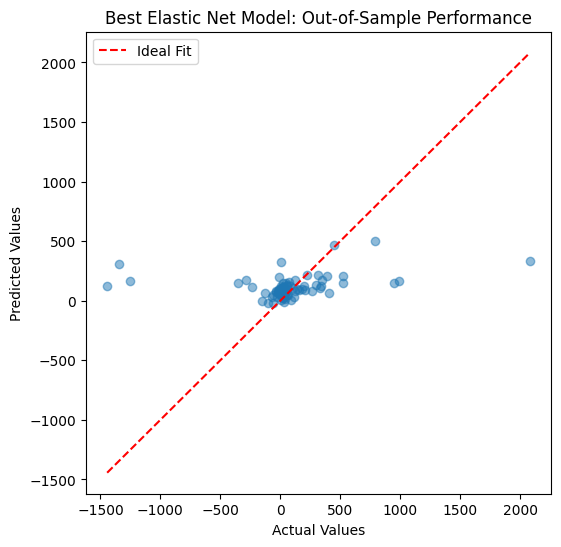

In [23]:
# Generate scatterplot for the best model
if best_model:
    # Get predictions from the best model
    y_pred_scaled = best_model.predict(X_val_scaled)

    # **Inverse transform predictions and actual values**
    y_pred = netyscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Scatterplot of predicted vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_Netflow_val, y_pred, alpha=0.5)

    # Plot y = x line for reference
    min_val, max_val = min(y_Netflow_val.min(), y_pred.min()), max(y_Netflow_val.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit")

    # Set log scale
    plt.xscale("log")
    plt.yscale("log")
    
    # Labels and title
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Best Elastic Net Model: Out-of-Sample Performance")
    plt.legend()

    # Show the plot
    plt.show()

# Generate scatterplot for the best model
if best_model:
    # Get predictions from the best model
    y_pred_scaled = best_model.predict(X_val_scaled)

    # **Inverse transform predictions and actual values**
    y_pred = netyscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Scatterplot of predicted vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_Netflow_val, y_pred, alpha=0.5)

    # Plot y = x line for reference
    min_val, max_val = min(y_Netflow_val.min(), y_pred.min()), max(y_Netflow_val.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit")
    
    # Labels and title
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Best Elastic Net Model: Out-of-Sample Performance")
    plt.legend()

    # Show the plot
    plt.show()

In [24]:
# Compute validation MSE on the original scale
val_mse_original_scale = mean_squared_error(y_Netflow_val_scaled, y_pred)
print(f"Validation MSE (Original Scale): {val_mse_original_scale:.4f}")
val_rmse_original_scale = np.sqrt(mean_squared_error(y_Netflow_val, y_pred))
print(f"Validation RMSE (Original Scale): {val_rmse_original_scale:.4f}")

Validation MSE (Original Scale): 20746.0196
Validation RMSE (Original Scale): 404.9178


In [25]:
import pandas as pd

# Calculate residuals (difference between actual and predicted values)
residuals = y_Netflow_val - y_pred

# Create a DataFrame to store actual values, predicted values, and residuals for easy manipulation
residuals_df = pd.DataFrame({
    'Actual': y_Netflow_val,
    'Predicted': y_pred,
    'Residual': residuals
})

# Sort the DataFrame by absolute residuals (descending order)
sorted_residuals_df = residuals_df.reindex(residuals_df['Residual'].abs().sort_values(ascending=False).index)

# Display the top N rows with the largest residuals
top_n = 10  # You can change this number to see more or fewer rows
print(f"Top {top_n} data points with largest residuals:")
print(sorted_residuals_df.head(top_n))

Top 10 data points with largest residuals:
     Actual   Predicted     Residual
229  2082.0  336.920766  1745.079234
404 -1343.0  308.933329 -1651.933329
299 -1444.0  125.513789 -1569.513789
103 -1252.0  162.149722 -1414.149722
495   991.0  164.078969   826.921031
411   948.0  152.749646   795.250354
474  -351.0  145.872250  -496.872250
418  -284.0  172.029846  -456.029846
166   519.0  148.985427   370.014573
131  -232.0  116.331563  -348.331563



Final Model Trained on Train + Validation Set
Selected Parameters: {'alpha': 0.25, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 1500, 'selection': 'random', 'tol': 0.0005}
In-sample RMSE: 0.8356


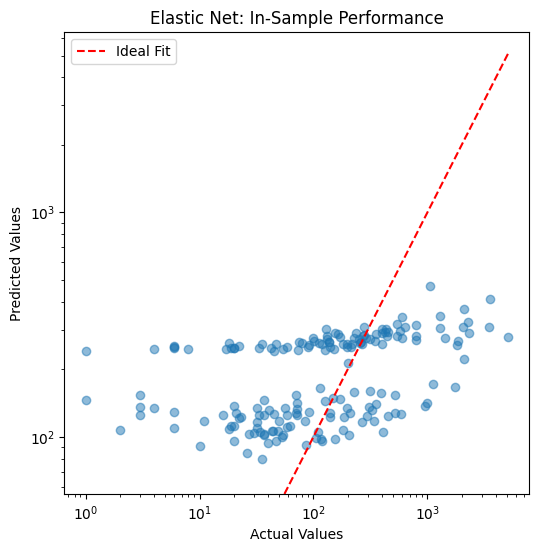

In [26]:
# In-sample accuracy for trainPLUSval set

# Initialize the best model with the optimal parameters found
best_model = ElasticNet(**best_params)

# Train on the combined dataset
best_model.fit(X_trainPLUSval_scaled, y_Netflow_trainPLUSval_scaled)

# Predict on the train+val set
y_trainval_pred_scaled = best_model.predict(X_trainPLUSval_scaled)

# Compute in-sample RMSE (on scaled values)
trainval_rmse_scaled = np.sqrt(mean_squared_error(y_Netflow_trainPLUSval_scaled, y_trainval_pred_scaled))

# Convert RMSE back to original scale
trainval_rmse_original = netyscaler.inverse_transform([[trainval_rmse_scaled]])[0, 0]

# Print final results
print("\nFinal Model Trained on Train + Validation Set")
print(f"Selected Parameters: {best_params}")
print(f"In-sample RMSE: {trainval_rmse_scaled:.4f}")

# Generate scatterplot for the best model
if best_model:
    # Get predictions from the best model
    y_pred_scaled = best_model.predict(X_trainPLUSval_scaled)

    # **Inverse transform predictions and actual values**
    y_pred = netyscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Scatterplot of predicted vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_Netflow_trainPLUSval, y_pred, alpha=0.5)

    # Plot y = x line for reference
    min_val, max_val = min(y_Netflow_trainPLUSval.min(), y_pred.min()), max(y_Netflow_trainPLUSval.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit")
    
    # Labels and title
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Elastic Net: In-Sample Performance")
    plt.legend()

    plt.xscale('log')
    plt.yscale('log')

    # Show the plot
    plt.show()

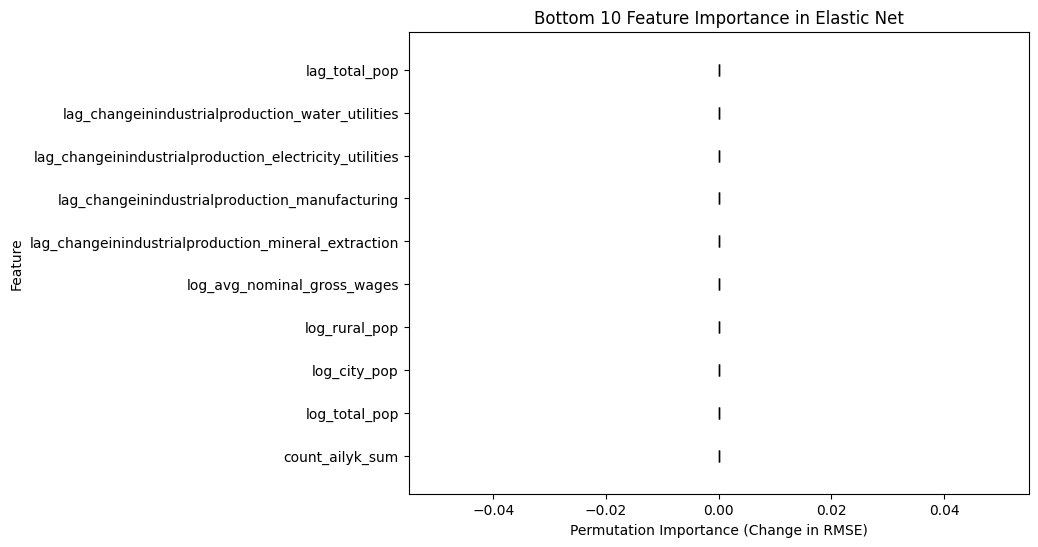

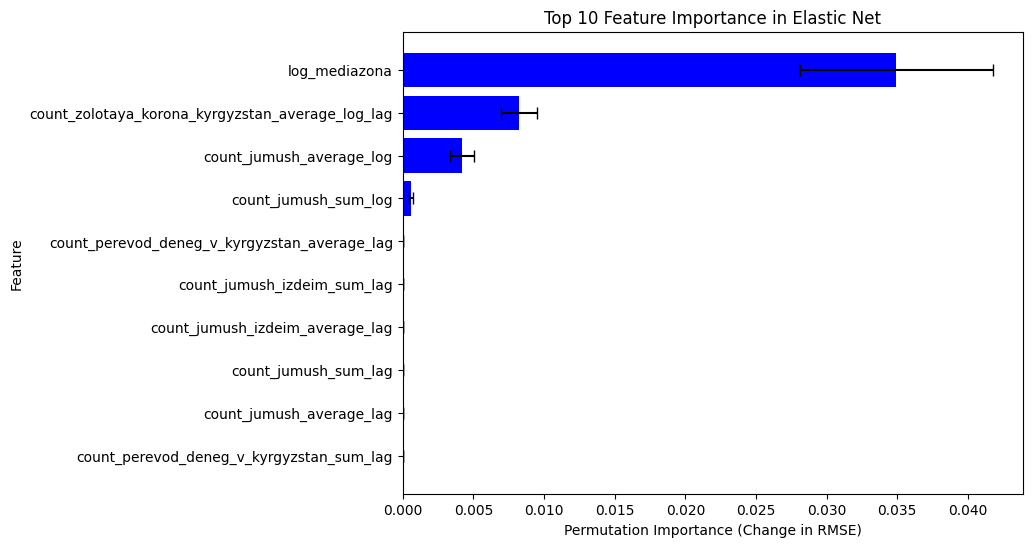

In [27]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Compute permutation importance
result = permutation_importance(
    best_model, X_trainPLUSval_scaled, y_Netflow_trainPLUSval_scaled, 
    scoring='neg_root_mean_squared_error', n_repeats=10, random_state=42
)

feature_names = X_trainPLUSval.columns  # Extract column names

# Sort by importance
sorted_idx = result.importances_mean.argsort()

# Select bottom 10 (least important) and top 10 (most important) features
bottom_10_idx = sorted_idx[:10]  # First 10 (least important)
top_10_idx = sorted_idx[-10:]    # Last 10 (most important)

# Plot bottom 10 features
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[bottom_10_idx], result.importances_mean[bottom_10_idx], 
         xerr=result.importances_std[bottom_10_idx], capsize=4, color="gray")
plt.xlabel("Permutation Importance (Change in RMSE)")
plt.ylabel("Feature")
plt.title("Bottom 10 Feature Importance in Elastic Net")
plt.show()

# Plot top 10 features
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[top_10_idx], result.importances_mean[top_10_idx], 
         xerr=result.importances_std[top_10_idx], capsize=4, color="blue")
plt.xlabel("Permutation Importance (Change in RMSE)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance in Elastic Net")
plt.show()


In [28]:
# Predict on the train+val set
X_scaled = X_scaled.drop(columns="Year")
y_Netflow_fitted_values = best_model.predict(X_scaled)

In [29]:
# Add the 'Year' column back to the X_scaled DataFrame
year_column = X['Year']
X_scaled['Year'] = year_column

X_scaled.reset_index(drop=True, inplace=True)
y_Netflow_fitted_values = y_Netflow_fitted_values[:X_scaled.shape[0]]  # Make sure y values match X's number of rows

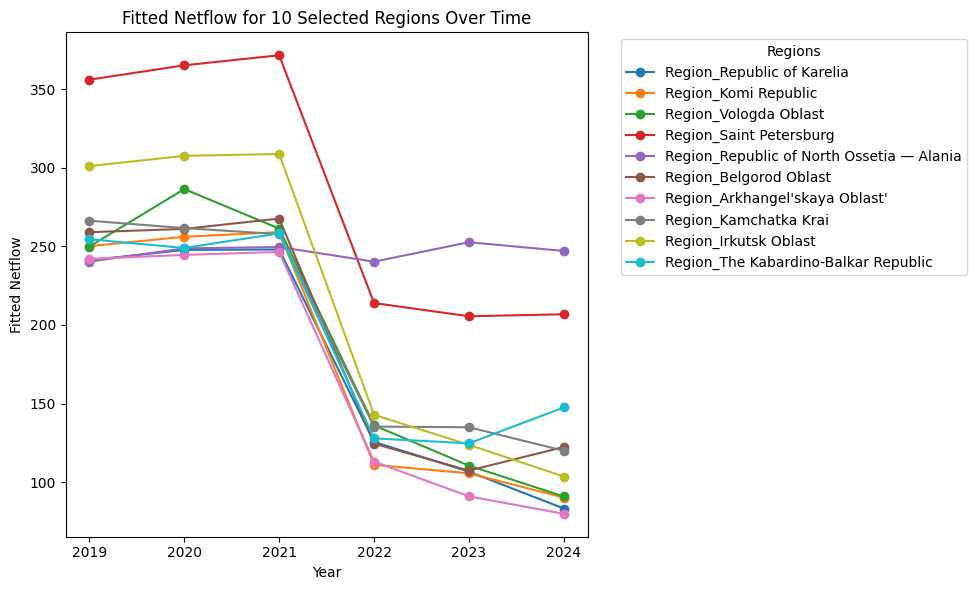

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'best_model' is your fitted model and 'X_scaled' is your training data with region dummies
# Identify the region columns (columns that contain 'Region' in their name)
region_columns = X_scaled.filter(regex='Region').columns

# Randomly select 10 regions from the available dummy columns
random_regions = np.random.choice(region_columns, size=10, replace=False)

# Extract 'Year' from X_scaled (assuming it's in the original X matrix, which might have been scaled)
years = X_scaled['Year'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Loop through the random regions to plot their corresponding fitted values over time (Years)
for region in random_regions:
    # Select rows where the region dummy variable is 1 (indicating that the region applies to that row)
    region_data_indices = X_scaled[X_scaled[region] == 1].index
    
    # Extract the corresponding years and fitted values for this region
    region_years = X_scaled.loc[region_data_indices, 'Year']
    region_fitted_values = y_Netflow_fitted_values[region_data_indices]
    
    # Inverse transform the fitted values using y_scaler
    region_fitted_values = netyscaler.inverse_transform(region_fitted_values.reshape(-1, 1)).flatten()
    
    # Plot fitted values for this region over the years
    plt.plot(region_years, region_fitted_values, label=region, marker='o')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Fitted Netflow')
plt.title('Fitted Netflow for 10 Selected Regions Over Time')
plt.legend(title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Number of bootstrap iterations
n_iterations = 1000
predictions = []

# Initialize list to collect results
results = []

# Perform bootstrapping
for i in range(n_iterations):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X_trainPLUSval_scaled, y_Netflow_trainPLUSval_scaled, random_state=i)
    
    # Fit the model on the resampled data
    best_model.fit(X_resampled, y_resampled)
    
    # Predict the values for the resampled data
    y_pred_resampled = best_model.predict(X_resampled)
    
    # Store the predictions
    predictions.append(y_pred_resampled)

# Convert predictions list to a numpy array
predictions = np.array(predictions)
std_deviation = np.std(predictions, axis=0)

In [32]:
# Create the 90% confidence interval using +/- 1.645 standard deviations (for 90% CI)
std_deviation_mean = np.mean(std_deviation)
conf_interval_factor = 1.645  # For 90% confidence interval
lower_bound = y_Netflow_fitted_values - conf_interval_factor * std_deviation_mean
upper_bound = y_Netflow_fitted_values + conf_interval_factor * std_deviation_mean

In [33]:
# Reshape to 2D before applying inverse_transform if the scaler was fit on multiple columns
y_Netflow_fitted_values = netyscaler.inverse_transform(y_Netflow_fitted_values.reshape(-1, 1))  # Reshape to 2D
lower_bound = netyscaler.inverse_transform(lower_bound.reshape(-1, 1))  # Reshape to 2D
upper_bound = netyscaler.inverse_transform(upper_bound.reshape(-1, 1))  # Reshape to 2D

# Flatten to return to 1D after inverse transformation
y_Netflow_fitted_values = y_Netflow_fitted_values.flatten()
lower_bound = lower_bound.flatten()
upper_bound = upper_bound.flatten()

# Create a DataFrame with Year, fitted values, lower and upper bounds
df_fitted_values = pd.DataFrame({
    'Year': year_column, 
    'Region' : region_year_copy['Region'],
    'Fitted Values': y_Netflow_fitted_values,  # Your fitted values
    'Lower Bound': lower_bound,  # Lower confidence interval bound
    'Upper Bound': upper_bound  # Upper confidence interval bound
})

# Display the resulting DataFrame
print(df_fitted_values.head(100))

     Year                      Region  Fitted Values  Lower Bound  Upper Bound
1    2019                  Altai Krai     266.455949    47.990989   484.920908
2    2020                  Altai Krai     289.422558    70.957599   507.887518
3    2021                  Altai Krai     301.597179    83.132220   520.062139
4    2022                  Altai Krai     122.413594   -96.051366   340.878553
5    2023                  Altai Krai     105.544795  -112.920165   324.009754
..    ...                         ...            ...          ...          ...
111  2024              Kamchatka Krai     119.960065   -98.504895   338.425024
113  2019  Karachay-Cherkess Republic     252.767877    34.302918   471.232837
114  2020  Karachay-Cherkess Republic     251.134954    32.669994   469.599913
115  2021  Karachay-Cherkess Republic     248.437175    29.972216   466.902135
116  2022  Karachay-Cherkess Republic     125.083821   -93.381138   343.548781

[100 rows x 5 columns]


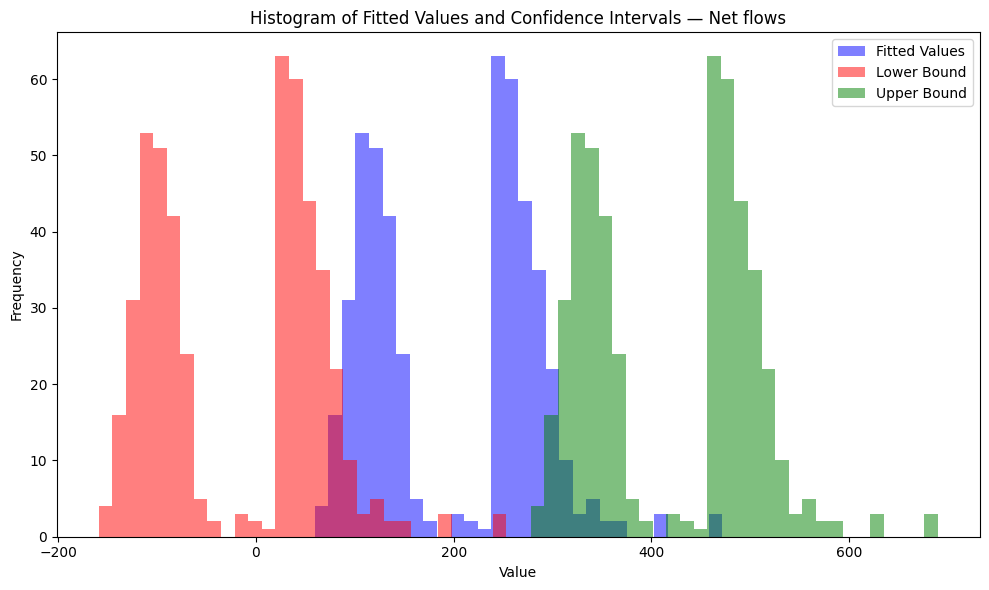

In [34]:
import matplotlib.pyplot as plt

# Plot histogram for the inverse-transformed fitted values, lower bound, and upper bound
plt.figure(figsize=(10, 6))

# Plot histogram for Fitted Values
plt.hist(df_fitted_values['Fitted Values'], bins=30, alpha=0.5, label='Fitted Values', color='blue')

# Plot histogram for Lower Bound
plt.hist(df_fitted_values['Lower Bound'], bins=30, alpha=0.5, label='Lower Bound', color='red')

# Plot histogram for Upper Bound
plt.hist(df_fitted_values['Upper Bound'], bins=30, alpha=0.5, label='Upper Bound', color='green')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Fitted Values and Confidence Intervals — Net flows')
plt.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

In [35]:
# Optionally, save the DataFrame to a CSV file for further analysis
df_fitted_values.to_csv('/Users/michelle/Documents/thesis/extended_time_series_Netflows_WITHeconomiccovariates.csv', index=False)

### Repeat this process for outflows

### Repeat this process for outflows

## __Part 2:__ Extending the 2010-16 monthly stock dataset